# Cifar-10 이미지 분류(Data Augmentation)

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np

In [2]:
# seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# 나중에 지정될 변수의 값을 미리 세팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')

In [4]:
# The data, split between train and test sets:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 데이터 확인 및 전처리

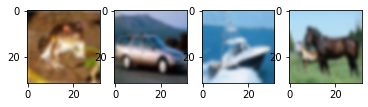

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation="bicubic")
plt.subplot(142)
plt.imshow(x_train[4], interpolation="bicubic")
plt.subplot(143)
plt.imshow(x_train[8], interpolation="bicubic")
plt.subplot(144)
plt.imshow(x_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

In [6]:
# 자료형을 실수로 변환한 후 정규화
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [14]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

### 모델 정의/설정/학습

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [10]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/cifar10-aug-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, stratify=y_train, test_size=0.2, random_state=seed
)

In [16]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,   # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,    # epsilon for ZCA whitening
    rotation_range=0,     # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,   # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,   # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [17]:
history = model.fit(datagen.flow(x_train, y_train,
                                batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = (x_valid, y_valid),
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/100
1250/1250 [==============================] - 22s 16ms/step - loss: 2.0821 - accuracy: 0.2234 - val_loss: 1.6719 - val_accuracy: 0.3948

Epoch 00001: val_loss improved from inf to 1.67186, saving model to model/cifar10-aug-01-1.6719.hdf5
Epoch 2/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6935 - accuracy: 0.3795 - val_loss: 1.4395 - val_accuracy: 0.4771

Epoch 00002: val_loss improved from 1.67186 to 1.43953, saving model to model/cifar10-aug-02-1.4395.hdf5
Epoch 3/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5554 - accuracy: 0.4384 - val_loss: 1.3647 - val_accuracy: 0.4981

Epoch 00003: val_loss improved from 1.43953 to 1.36466, saving model to model/cifar10-aug-03-1.3647.hdf5
Epoch 4/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4622 - accuracy: 0.4716 - val_loss: 1.2818 - val_accuracy: 0.5373

Epoch 00004: val_loss improved from 1.36466 to 1.28180, saving model to model/cifar10-aug-04-1.28

In [18]:
from tensorflow.keras.models import load_model
best_model = load_model('./model/cifar10-aug-63-0.6494.hdf5')

In [19]:
# 테스트 정확도 출력 
acc = model.evaluate(x_test, y_test, verbose=2)[1]
print(f"\n Test Accuracy: {acc:.4f}")

313/313 - 1s - loss: 0.7272 - accuracy: 0.7748

 Test Accuracy: 0.7748


### 훈련과정 시각화

In [20]:
# 검증셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']

# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

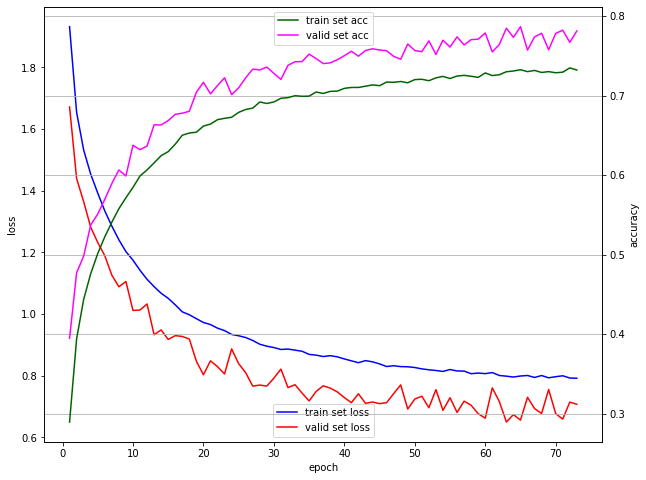

In [25]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='valid set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='valid set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()